In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import numpy as np
from math import pi
import pandas as pd
import scipy.stats as ss
import matplotlib.pyplot as plt # gráficos
import sys

In [ ]:
flag_runlocal  = True    # "False" para ejecutar en google colab
flag_useserver = True    # "False" para ejecutar con coneeción a internet via proxy

In [ ]:
if flag_runlocal:
    # ---> Ejecución local
    pathBayesInfer = ''
    if flag_useserver:
        from ConfigProxy import proxy
        # Set the proxy with authentication
        import os
        os.environ['http_proxy'] = proxy
        os.environ['https_proxy'] = proxy

else:
    # ---> Desde github-to-colab
    !git clone https://github.com/Alledar/BayesInfer.git
    pathBayesInfer = '/content/BayesInfer/'

sys.path.append(pathBayesInfer+'02_Libraries')
import KFstuff as KF
from GeneralComplements import matprint

 # Clark's double-drift unobserved components model

Clark propone que el PBI puede descomponence en componentes tendenciales y cíclicos. [Zivot y Kum](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=877398) estudian extensiones del modelo de Clark y formulan condiciones para identificar coeficientes.

En este ejercicio, utilizaremos el KF para estimar el modelo de Clark con la propuesta de Zivot y Kum utilizando data peruana. 

El modelo es

$y_t = \bar{y}_t + x_t + \gamma_t + \varepsilon_t$ con $\varepsilon_t\sim\mathcal{N}(0,\sigma_{e,y}^2)$

$g_t = g_{t-1} + \mu_{g,t}$

$\bar{y}_t = \bar{y}_{t-1} + g_{t-1} + \mu_{y,t}$

$x_t = \phi_1x_{t-1} + \phi_2x_{t-2} + \mu_{x,t}$

$\gamma_t = \mu_{\gamma,t} - \gamma_{t-1} - \gamma_{t-2} - \gamma_{t-3}$

donde 



$\begin{bmatrix}\mu_{g,t}\\ \mu_{y,t}\\ \mu_{x,t}\\ \mu_{\gamma,t}\end{bmatrix}\sim\mathcal{N}\left(\mathbf{0},
\begin{bmatrix}\sigma_{u,g}^2 & 0 & 0 & 0\\ 
0 & \sigma_{u,y}^2 & \rho\sigma_{u,y}\sigma_{x,y} & 0 \\ 
0 & \rho\sigma_{u,y}\sigma_{x,y} & \sigma_{u,x}^2 & 0\\ 
0 & 0 & 0 & \sigma_{u,\gamma}^2\end{bmatrix}
\right)$

con $\phi_1=2\omega_1\cos(\omega_2)$ y $\phi_2=-\omega_1^2$ y $SNR = \frac{\sigma_{u,x}^2}{(1-\phi_1^2-\phi_2^2-2\phi_1\phi_2)\sigma_{u,y}^2}$

Las variables $y_t$, $\bar{y}_t$, $x_t$ y $\gamma_t$ son el logaritmo del PBI, su tendencia, el ciclo y el factor estacional, respectivamente. La variable $g_t$ es el crecimiento tendencial.

Note que se está asumiendo que $y_t\sim\mathcal{I}(2)$ pues la tendencia $\bar{y}_t$ tiene 2 raíces unitarias, una de ellas es el intercepto $g_t$ que es una raiz unitaria en sí misma.

El ciclo $x_t$ está restringido tal que sea estacionario con descomposición espectral de raíz compleja donde se controla la amplitud (mediante $\theta_1$) y la frecuencia (mediante $\theta_2$). Esto es:

$x_t = \phi_1x_{t-1} + \phi_2x_{t-2} + \mu_{x,t}\Rightarrow (1-\phi_1L - \phi_2L^2)x_t = \mu_{x,t}$

las raices del polinomio caracteristicos son

$1-\phi_1z - \phi_2z^2=0 \Rightarrow z=\frac{-\theta_1\pm\sqrt{\phi_1^2+4\phi_2}}{2\phi_2}=\frac{-2\omega_1\cos(\omega_2)\pm\sqrt{(2\omega_1\cos(\omega_2))^2-4\omega_1^2}}{-2\omega_1^2}$

$z=\frac{\cos(\omega_2)}{\omega_1}\pm\frac{\sin(\omega_2)}{\omega_1}i$

## Cargemos la data

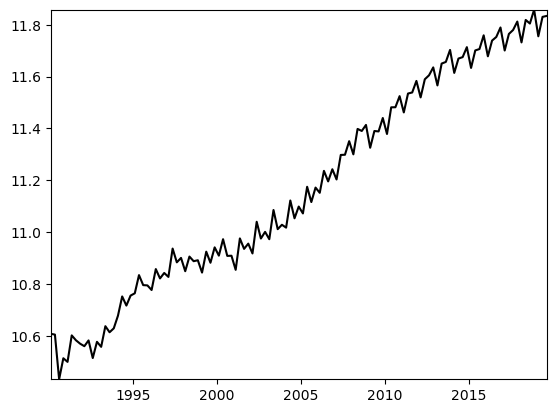

In [3]:
df = pd.read_csv(pathBayesInver+'03_Inputs/PBI_BCRP.csv')
df = df[40:] # data del 90 en adelante
data = np.log(df['PBI'].values)
nobs = data.size
data = np.reshape(data,(nobs,1))
dates = 1990.125+np.array(list(range(nobs)))/4
fig, axs = plt.subplots(1,1)
axs.plot(dates,data,'k')
axs.autoscale(enable=True, axis='both', tight=True)

## Representación de SS
Definamos
$\textbf{y}_t=y_t$ $\boldsymbol{\alpha}_t=[g_t,\ \bar{y}_t,\ x_t,\ x_{t-1},\ \gamma_{t},\ \gamma_{t-1},\ \gamma_{t-2}]'$ $\boldsymbol{\eta}_t=[\mu_{g,t},\ \mu_{y,t}\ \mu_{x,t},\ \mu_{\gamma,t}]$

Entonces la representación de SS es

$\textbf{y}_t = [0\ 1\ 1\ 0\ 1\ 0\ 0]\boldsymbol{\alpha}_t + \varepsilon_t$

$\boldsymbol{\alpha}_{t+1} = \begin{bmatrix}
1 & 0 & 0 & 0 & 0 & 0 & 0 \\
1 & 1 & 0 & 0 & 0 & 0 & 0  \\
0 & 0 & \phi_1 & \phi_2 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & -1 & -1 & -1 \\
0 & 0 & 0 & 0 & 1 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 1 & 0 \\
\end{bmatrix}\boldsymbol{\alpha}_{t} + 
\begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 0 \\
0 & 0 & 0 & 1 \\
0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 \\
\end{bmatrix}\boldsymbol{\eta}_{t}
$

Calibración inicial de parámetros

In [4]:
omega1_0 =  0.4**(1/2)
omega2_0 =  np.arccos(1.2/(2*omega1_0))
phi1_0   =  2*omega1_0*np.cos(omega2_0)
phi2_0   = -omega1_0**2
sey2_0   =  0.05**2
sux2_0   =  0.2**2
SNR      =  1600
suy2_0   =  sux2_0/(SNR*(1-phi1_0**2-phi2_0**2-2*phi1_0*phi2_0))
sug2_0   =  0.05**2
sugm2_0  =  0.05**2
rho_0    = -0.1329

In [5]:
T = np.zeros(shape=(7,7))
T[0,0]=1
T[1,[0,1]]=1
T[2,[2,3]]=[phi1_0, phi2_0]
T[3,2]=1
T[4,[4,5,6]]=-1
T[5:,4:6] = np.identity(2)
R = np.zeros(shape=(7,4))
R[0:3,0:3] = np.identity(3)
R[4,3] = 1
Z = np.array([[0,1,1,0,1,0,0]])
H = np.array([[sey2_0]])
Q = np.diag([sug2_0,suy2_0,sux2_0,sugm2_0])
Q[1,2]=rho_0*np.sqrt(suy2_0*sux2_0)
Q[2,1]=rho_0*np.sqrt(suy2_0*sux2_0)
alpha0 = np.array([0,0,0,0,0,0,0])
Sigma_a0 = np.identity(7)*1e4

print('Matrix T: Matriz de transición')
matprint(T)
print('')
print('Matrix Q: Covarianzas de transición')
matprint(Q)
print('')
print('Matrix Z: Matriz de medidas (o carga)')
matprint(Z)
print('')
print('Matrix H: Covarianzas de errores de medida')
matprint(H)

Matrix T: Matriz de transición
1  0  0  0  0  0  0
1  1  0  0  0  0  0
0  0  1.2  -0.4  0  0  0
0  0  1  0  0  0  0
0  0  0  0  -1  -1  -1
0  0  0  0  1  0  0
0  0  0  0  0  1  0

Matrix Q: Covarianzas de transición
0.0025  0  0  0
0  6.94444e-05  -0.0002215  0
0  -0.0002215  0.04  0
0  0  0  0.0025

Matrix Z: Matriz de medidas (o carga)
0  1  1  0  1  0  0

Matrix H: Covarianzas de errores de medida
0.0025


La función ```KFplus(.)``` implementa el KF, recibe como argumentos la data y un dicionario con la información requerida para el KF (matrices y puntos iniciales)

el dicionario se llama ```mod``` y los campos mínimos requeridos son $Z$,$T$,$R$,$H$,$Q$,$\alpha_{0|0}$ y $\Sigma_{0|0}^\alpha$

In [6]:
mod = {'Z':Z,'T':T,'R':R,'H':H,'Q':Q}
ops = {'a_initial':alpha0,'P_initial':Sigma_a0}

In [7]:
mod['R']

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

En la siguiente linea, ```Basic_KF(.)``` estima la trayectoria de estados, condicional a la data y las matrices calibradas

In [8]:
mod0 = mod
mod0['alpha0'] = alpha0
mod0['Sigma_a0'] = Sigma_a0
mod0_filtered = KF.Basic_KF(data,mod)

Dibujamos las series suavizadas ```a_s``` y sus desviaciones estándar ```a_s_std```

In [9]:
a_s=mod0_filtered['a_s']
a_s_std=mod0_filtered['a_s_std']

In [10]:
def plot_Clark(lastperiods,a_s,a_s_up,a_s_down,dates):
    fig, axs = plt.subplots(2,2)

    nobs = a_s[:,2].size
    
    Output_Gap = a_s[:,2]*100
    Output_up = a_s_up[:,2]*100
    Output_down = a_s_down[:,2]*100
    axs[0,0].plot(dates[-lastperiods:],Output_Gap[-lastperiods:],'b')
    axs[0,0].plot(dates[-lastperiods:],Output_up[-lastperiods:],'--r')
    axs[0,0].plot(dates[-lastperiods:],Output_down[-lastperiods:],'--r')
    axs[0,0].axhline(0, color='g', lw=1)
    axs[0,0].autoscale(enable=True, axis='both', tight=True)
    axs[0,0].set_title('Brecha del producto')

    Output_Trend = a_s[:,1]
    Output_Trend_up = a_s_up[:,1]
    Output_Trend_down = a_s_down[:,1]
    data_sa = np.reshape(a_s[:,1]+a_s[:,2],(nobs,1))
    axs[0,1].plot(dates[-lastperiods:],Output_Trend_up[-lastperiods:],'--r')
    axs[0,1].plot(dates[-lastperiods:],Output_Trend_down[-lastperiods:],'--r')
    axs[0,1].plot(dates[-lastperiods:],Output_Trend[-lastperiods:],'b')
    axs[0,1].plot(dates[-lastperiods:],data_sa[-lastperiods:],'k')
    axs[0,1].autoscale(enable=True, axis='both', tight=True)
    axs[0,1].set_title('PBI y Tendencia')

    Growth_Trend = a_s[:,0]*400
    Growth_Trend_up = a_s_up[:,0]*400
    Growth_Trend_down = a_s_down[:,0]*400
    Growth_data  = np.r_[np.zeros(shape=(1,1)),np.diff(data_sa,1,0)]*400
    axs[1,0].plot(dates[-lastperiods:],Growth_Trend[-lastperiods:],'b')
    axs[1,0].plot(dates[-lastperiods:],Growth_Trend_up[-lastperiods:],'r')
    axs[1,0].plot(dates[-lastperiods:],Growth_Trend_down[-lastperiods:],'r')
    axs[1,0].plot(dates[-lastperiods:],Growth_data[-lastperiods:],'k')
    axs[1,0].axhline(0, color='g', lw=1)
    axs[1,0].autoscale(enable=True, axis='both', tight=True)
    axs[1,0].set_title('Crecimiento tendencial')

    SeasFact = a_s[:,4]
    SeasFact_up = a_s_up[:,4]
    SeasFact_down = a_s_down[:,4]
    axs[1,1].plot(dates[-lastperiods:],SeasFact[-lastperiods:],'b')
    axs[1,1].plot(dates[-lastperiods:],SeasFact_up[-lastperiods:],'--r')
    axs[1,1].plot(dates[-lastperiods:],SeasFact_down[-lastperiods:],'--r')
    axs[1,1].axhline(0, color='g', lw=1)
    axs[1,1].autoscale(enable=True, axis='both', tight=True)
    axs[1,1].set_title('Factor estacional')

    plt.tight_layout()
    
    return

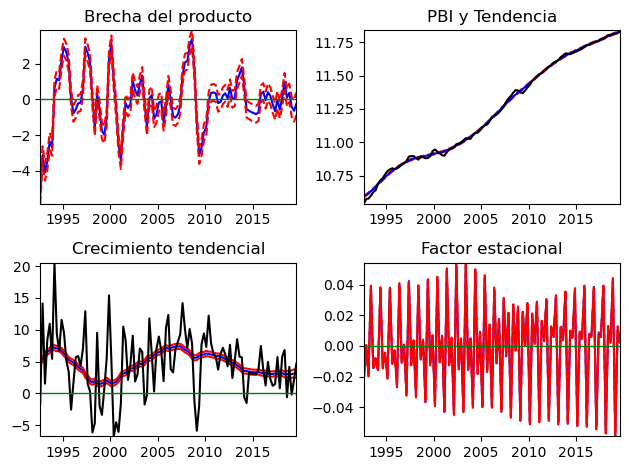

In [11]:
lastperiods = 119-10
a_s_up = a_s+1.96*a_s_std/nobs # corregir: eliminar "/nobs"
a_s_down = a_s-1.96*a_s_std/nobs # corregir: eliminar "/nobs"
plot_Clark(lastperiods,a_s,a_s_up,a_s_down,dates)

In [12]:
a_s=mod0_filtered['a_s']
a_p=mod0_filtered['a_p']
a_u=mod0_filtered['a_u']

Text(0.5, 1.0, 'PBI y Tendencia')

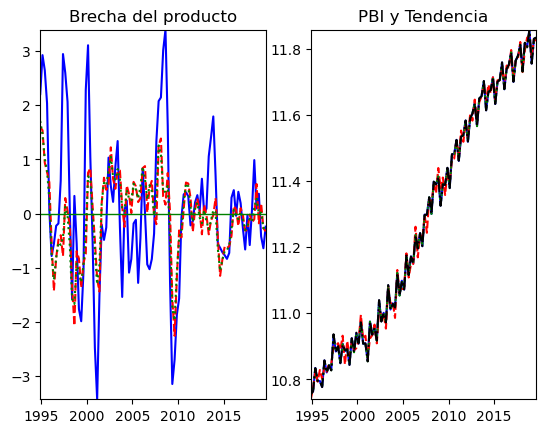

In [13]:
fig, axs = plt.subplots(1,2)
lastperiods =  100
nobs = a_s[:,2].size
    
Output_p = a_p[:,2]*100
Output_u = a_u[:,2]*100
Output_s = a_s[:,2]*100
axs[0].plot(dates[-lastperiods:],Output_s[-lastperiods:],'b')
axs[0].plot(dates[-lastperiods:],Output_p[-lastperiods:],'--r')
axs[0].plot(dates[-lastperiods:],Output_u[-lastperiods:],':g')
axs[0].axhline(0, color='g', lw=1)
axs[0].autoscale(enable=True, axis='both', tight=True)
axs[0].set_title('Brecha del producto')

Output_p = a_p[:,1]+a_p[:,2]+a_p[:,4]
Output_u = a_u[:,1]+a_u[:,2]+a_u[:,4]
Output_s = a_s[:,1]+a_s[:,2]+a_s[:,4]
axs[1].plot(dates[-lastperiods:],Output_s[-lastperiods:],'b')
axs[1].plot(dates[-lastperiods:],Output_p[-lastperiods:],'--r')
axs[1].plot(dates[-lastperiods:],Output_u[-lastperiods:],':g')
axs[1].plot(dates[-lastperiods:],data[-lastperiods:],'-.k')
axs[1].autoscale(enable=True, axis='both', tight=True)
axs[1].set_title('PBI y Tendencia')

In [14]:
mod_filtered = KF.KFplus(data,mod,ops)

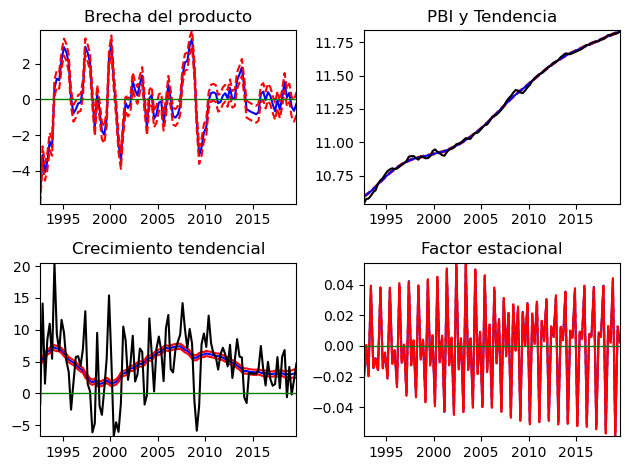

In [46]:
a_s=mod_filtered['a_s']
a_s_std=mod_filtered['a_s_std']
lastperiods = 119-10
a_s_up = a_s+1.96*a_s_std/nobs # corregir: eliminar "/nobs"
a_s_down = a_s-1.96*a_s_std/nobs # corregir: eliminar "/nobs"
plot_Clark(lastperiods,a_s,a_s_up,a_s_down,dates)

Text(0.5, 1.0, 'PBI y Tendencia')

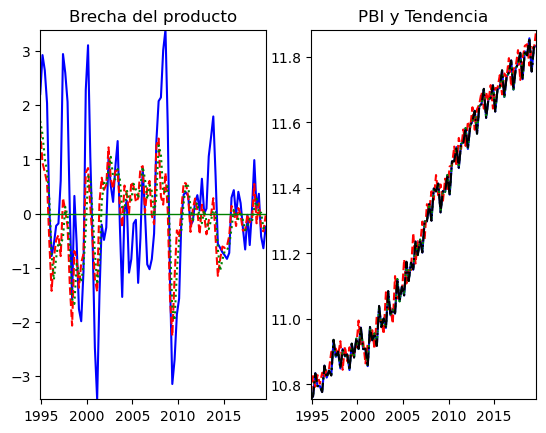

In [16]:
a_s=mod_filtered['a_s']
a_p=mod_filtered['a_p']
a_u=mod_filtered['a_u']
fig, axs = plt.subplots(1,2)
lastperiods =  100
nobs = a_s[:,2].size
    
Output_p = a_p[:,2]*100
Output_u = a_u[:,2]*100
Output_s = a_s[:,2]*100
axs[0].plot(dates[-lastperiods:],Output_s[-lastperiods:],'b')
axs[0].plot(dates[-lastperiods:],Output_p[-lastperiods:],'--r')
axs[0].plot(dates[-lastperiods:],Output_u[-lastperiods:],':g')
axs[0].axhline(0, color='g', lw=1)
axs[0].autoscale(enable=True, axis='both', tight=True)
axs[0].set_title('Brecha del producto')

Output_p = a_p[:,1]+a_p[:,2]+a_p[:,4]
Output_u = a_u[:,1]+a_u[:,2]+a_u[:,4]
Output_s = a_s[:,1]+a_s[:,2]+a_s[:,4]
axs[1].plot(dates[-lastperiods:],Output_s[-lastperiods:],'b')
axs[1].plot(dates[-lastperiods:],Output_p[-lastperiods:],'--r')
axs[1].plot(dates[-lastperiods:],Output_u[-lastperiods:],':g')
axs[1].plot(dates[-lastperiods:],data[-lastperiods:],'-.k')
axs[1].autoscale(enable=True, axis='both', tight=True)
axs[1].set_title('PBI y Tendencia')

## Estimación

### Máxima verosimilitud
Para estimar por maxima verosimilitud, debemos apilar los coeficientes a estimar en un vector $\theta$ y escribir una funcion tal que dados $\theta$ y la data, regrese la verosimilitud 

$\theta=\{\omega_1,\ w_2,\ s_{e,y}^2,\ s_{u,x}^2,\ s_{u,g}^2,\ s_{u,\gamma}^2,\ r\}$ donde

* $\omega_1\in(0,1)$ y $\omega_2=\frac{\pi}{20}+\left(\frac{\pi}{3}-\frac{\pi}{20}\right)w_2\in[\frac{\pi}{20},\frac{\pi}{3}]$ para $w_2\in[0,1]$

* $\sigma_j^2>0$

* $\sigma_{u,y}^2 = \frac{\sigma_{u,x}^2}{[1-(2\omega_1\cos(\omega_2))^2-\omega_1^4]SNR}$

* $\rho=2r-1\in[-1,1]$ para $r\in[0,1]$

1. Funcion de verosimilitud

In [17]:
def mod2work(theta,data,OnlyEstimate=True): 
    omega1 = theta[0]
    w2 = theta[1]        
    sey2 = theta[2]
    sug2 = theta[3]
    sux2 = theta[4]
    sugm2 = theta[5]
    nt = theta.size
    if nt>6:
        r = theta[6]
    else:
        r = (1+(-0.1329))/2 
    
    # Restriciones
    omega2 = pi/20+(pi/3-pi/20)*w2
    phi1 = 2*omega1*np.cos(omega2)
    phi2 = -omega1**2        
    S2NR = 1600
    suy2 = sux2/(S2NR*(1-phi1**2-phi2**2-2*phi1*phi2))
    rho = 2*r-1
    
    T = np.zeros(shape=(7,7))
    T[0,0]=1
    T[1,[0,1]]=1
    T[2,2]=phi1
    T[2,3]=phi2
    T[3,2]=1
    T[4,[4,5,6]]=-1
    T[5:,4:6] = np.identity(2)
    R = np.zeros(shape=(7,4))
    R[0:3,0:3] = np.identity(3)
    R[4,3] = 1
    Z = np.array([[0,1,1,0,1,0,0]])
    H = np.array([[sey2]])
    Q = np.diag([sug2,suy2,sux2,sugm2])
    Q[1,2]=rho*np.sqrt(suy2*sux2)
    Q[2,1]=rho*np.sqrt(suy2*sux2)
    alpha0 = np.array([0,0,0,0,0,0,0])
    Sigma_a0 = np.identity(7)*1e4

    mod = {'Z':Z,'T':T,'R':R,'H':H,'Q':Q}
    ops = {'only_likelihood':OnlyEstimate,'a_initial':alpha0,'P_initial':Sigma_a0,'compute_stderrors':True}
    
    return KF.KFplus(data,mod,ops)

Proponemos un punto inicial para la busqueda numérica del máximo:
> La función de verosimilitud es quasiconcava, por lo tanto la propuesta del punto inicial es muy importante

In [18]:
w2_0 = (omega2_0-pi/20)/(pi/3-pi/20)
r_0 = (1+rho_0)/2 
#             [w1      ,w2  ,sey   ,sug   ,sux   ,sugm   ,r  ]
x0 = np.array([omega1_0,w2_0,sey2_0,sug2_0,sux2_0,sugm2_0,r_0])
matprint(x0)

0.632456  0.184999  0.0025  0.0025  0.04  0.0025  0.43355


Que tan concava es la función en el punto inicial?

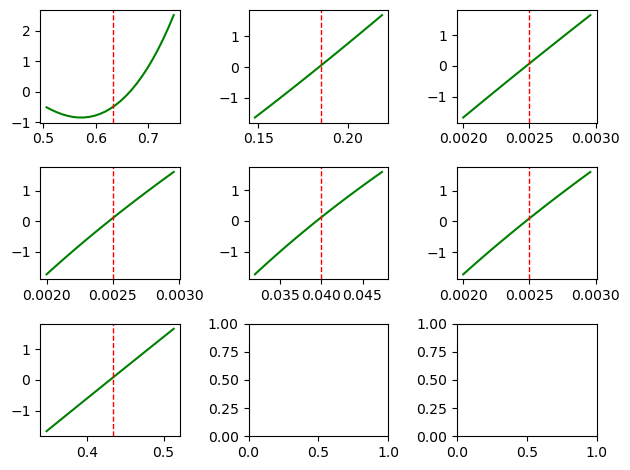

In [19]:
xup = x0*1.2
xdw = x0*0.8
KF.modecheck(mod2work, x0, xup, xdw, data)

Libreria para minimizar ```scipy.optimize```

In [20]:
from scipy.optimize import minimize

In [21]:
MinPos = 10**-6 # Numero pequeño positivo
from math import pi
# cotas = (min_vec max_vec)
bnds = ((MinPos, 1-MinPos), 
        (MinPos, 1-MinPos), 
        (MinPos,None),
        (MinPos,None),
        (MinPos,None),
        (MinPos,None),
        (MinPos, 1-MinPos))
#res = minimize(mod2work, x0, args=(data), method='TNC', options={'disp': True},bounds=bnds)
#res = minimize(mod2work, x0, args=(data), method='SLSQP', options={'disp': True},bounds=bnds)
#res = minimize(mod2work, x0, args=(data), method='trust-constr', options={'disp': True},bounds=bnds)
res = minimize(mod2work, x0, args=(data), method='L-BFGS-B', options={'disp': True},bounds=bnds)
#res = minimize(mod2work, x0, args=(data), method='BFGS', options={'disp': True})
#res = minimize(mod2work, x0, args=(data), options={'disp': True})

¿hay convergencia?

In [22]:
res.success

True

¿Que tan concava es la función en el vector estimado?

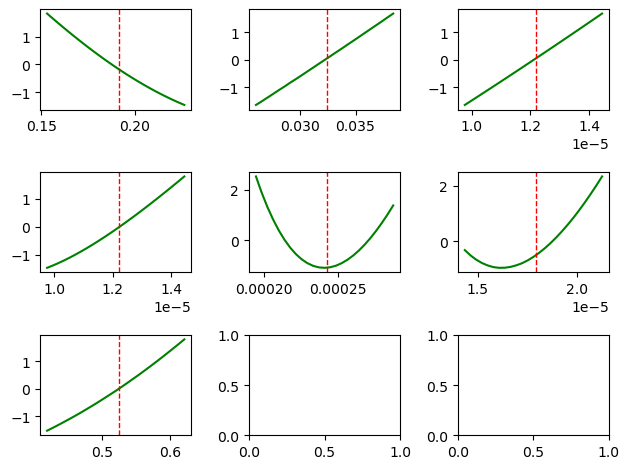

In [23]:
xopt = res.x.copy()
xup = xopt*1.20
xdw = xopt*0.80
KF.modecheck(mod2work, xopt, xup, xdw, data)

In [24]:
Theta_hat = res.x
hess_inv = res.hess_inv.todense() 
SDtheta_hat = np.diag((np.linalg.cholesky(res.hess_inv.todense())))

print('==============================')
print('Coef.       Est.     s.e.')
print('------------------------------')
coef = ['omega1    ','w2        ','sigma2_ey ','sigma2_ug ',
        'sigma2_ux ','sigma2_ugm','r         ']
for cc in range(7):
    print('%s  %2.4f  (%1.5f)'%(coef[cc],Theta_hat[cc],SDtheta_hat[cc]))
print('==============================')    

Coef.       Est.     s.e.
------------------------------
omega1      0.1915  (1190.85490)
w2          0.0325  (1.01746)
sigma2_ey   0.0000  (0.98172)
sigma2_ug   0.0000  (0.90539)
sigma2_ux   0.0002  (0.86420)
sigma2_ugm  0.0000  (0.00250)
r           0.5246  (0.02877)


Calculemos los estados suavizadas

In [25]:
modest = mod2work(res.x,data,False)

In [26]:
modest

{'a_p': array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  3.53586241e+00,  1.33054636e+00,
          3.53586241e+00, -3.53586241e+00,  3.53586241e+00,
          0.00000000e+00],
        [ 1.81994602e+00,  8.76741836e+00,  4.19919026e-01,
          1.50479677e+00, -1.81994603e+00,  2.15225779e+00,
          1.48763426e+00],
        [ 2.83858946e+00,  1.38344878e+01,  9.71156237e-02,
          3.96462404e-01, -1.58631178e+00, -9.60172938e-01,
          1.02652770e+00],
        [ 2.44241085e+00,  1.52109858e+01,  2.22320455e-02,
          9.80791367e-02,  1.36155158e+00, -2.35339972e+00,
         -2.94351575e-01],
        [ 1.13045192e+00,  1.27398882e+01,  5.84317828e-03,
          2.72276275e-02,  6.29860384e-01, -1.13737587e+00,
         -8.58436008e-02],
        [ 2.39945728e-02,  1.05616413e+01,  8.01357651e-05,
          3.84611797e-04, -6.33302833e-02,  6.34508

In [27]:
a_s=modest['a_s']
a_s_std=modest['a_s_std']

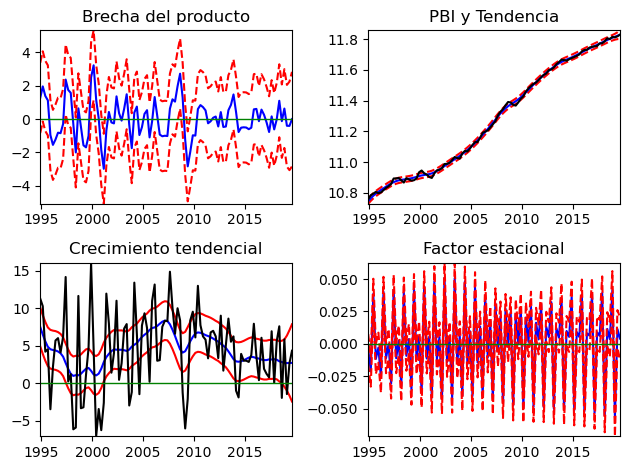

In [28]:
a_s_up = a_s+1.96*a_s_std
a_s_down = a_s-1.96*a_s_std
plot_Clark(lastperiods,a_s,a_s_up,a_s_down,dates)

### Estimación Bayesiana

Utilicemos los siguientes priors

$\omega_1\sim\mathcal{B}\left(0.5,0.25\right)$

$w_2\sim\mathcal{B}\left(0.5,0.25\right)$

$\sigma_{e,y}^2\sim \Gamma^{-1}(0.02,0.1)$

$\sigma_{u,g}^2\sim \Gamma^{-1}(0.05,0.25)$

$\sigma_{u,x}^2\sim \Gamma^{-1}(0.05,0.25)$

$\sigma_{u,gm}^2\sim \Gamma^{-1}(0.01,0.25)$

$\rho\sim \mathcal{N}(-0.10,0.25)$

In [29]:
def log_invGamma_PDF(x,u,s2):
    from math import gamma
    from numpy import exp, log
    if x>0:
        a = 2 + u**2/s2
        b = u*(1+u**2/s2)
        pdf = ((b**a)/gamma(a))*(x**(-a-1))*exp(-b/x)
    else:
        pdf = 0
    
    if pdf<10**(-10):
        log_pdf = -10**10
    else:
        log_pdf = log(pdf)
        log_pdf = log_pdf.item()
        
    return log_pdf

def log_norm_PDF(x,u,s2):
    from numpy import log
    out0 = -(1/2)*( log(s2)+(x-u)**2/s2 )
    return out0.item()

def log_Beta_PDF(x,u,s2):
    from math import gamma
    from numpy import exp, log
    if x>0:
        a = (u**2)*(1-u)/s2 - u
        b = a*( (1-u)/u )
        pdf_up = (x**(a-1))*((1-x)**(b-1))
        pdf_down = gamma(a)*gamma(b)/(gamma(a)+gamma(b))
        pdf = pdf_up/pdf_down
    else:
        pdf = 0
    
    if pdf<10**(-10):
        log_pdf = -10**10
    else:
        log_pdf = log(pdf)
        log_pdf = log_pdf.item()
        
    return log_pdf

1. Función para calcular la densidad del prior

In [30]:
def get_minus_log_prior(x,u,s2):
    omega1  = x[0]
    w2      = x[1]
    sey2    = x[2]
    sug2    = x[3]
    sux2    = x[4]
    sugm2   = x[5]
    r       = x[6]
    
    u_omg1  = u[0]
    u_w2    = u[1]
    u_sey2  = u[2]
    u_sug2  = u[3]
    u_sux2  = u[4]
    u_sugm2 = u[5]
    u_r     = u[6]
    
    s2_omg1  = s2[0]
    s2_w2    = s2[1]
    s2_sey2  = s2[2]
    s2_sug2  = s2[3]
    s2_sux2  = s2[4]
    s2_sugm2 = s2[5]
    s2_r     = s2[6]
    
    lp_0 = log_Beta_PDF(omega1,u_omg1,s2_omg1)
    lp_1 = log_Beta_PDF(w2,u_w2,s2_w2)
    lp_2 = log_invGamma_PDF(sey2,u_sey2,s2_sey2)
    lp_3 = log_invGamma_PDF(sug2,u_sug2,s2_sug2)
    lp_4 = log_invGamma_PDF(sux2,u_sux2,s2_sux2)
    lp_5 = log_invGamma_PDF(sugm2,u_sugm2,s2_sugm2)
    lp_6 = log_Beta_PDF(r,u_r,s2_r)
    
    return -(lp_0+lp_1+lp_2+lp_3+lp_4+lp_5+lp_6)

2. Función para calcular el negativo del posterior y su gradiente

In [31]:
def get_minus_log_posterior(theta,data,u,s2,OnlyEstimate=True):
    minus_log_prior = get_minus_log_prior(theta,u,s2)
    minus_log_like  = mod2work(theta,data,OnlyEstimate)
    if OnlyEstimate:
        return minus_log_like+minus_log_prior
    else:
        return minus_log_like['minuslogL']+minus_log_prior, minus_log_like
    
def get_minus_log_like(theta,data):
    minus_log_like  = mod2work(theta,data,True)
    return minus_log_like

3. Momentos del prior 

In [32]:
#u_prior            omega1,omega2,    sey2,    sug2,   sux2,   sugm2, rho
u_prior = np.array([   0.5 , 0.5, 0.01,0.02,0.1,0.05,   (1-0.1329)/2])
#s2_prior             omega1, omega2,  sey2,  sug2,  sux2, sugm2,   rho
s2_prior = np.array([   0.2 ,    0.2,    0.5,     0.5,     0.5,     0.5,  0.2])

In [33]:
x0

array([0.63245553, 0.184999  , 0.0025    , 0.0025    , 0.04      ,
       0.0025    , 0.43355   ])

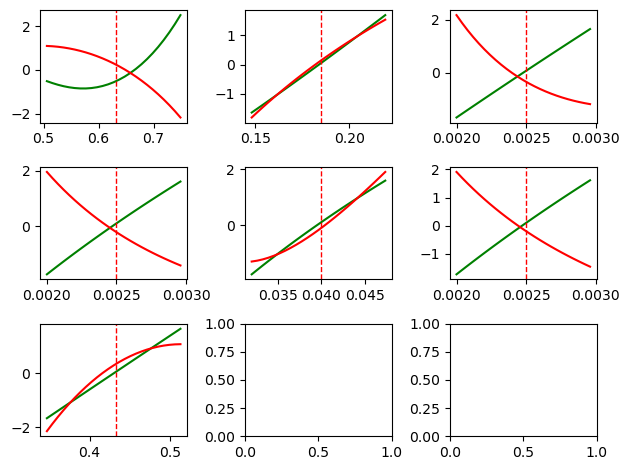

In [34]:
theta0 = x0.copy()
thetaup = theta0*1.2
thetadw = theta0*0.8
others = {'fcn1':get_minus_log_posterior,
          'u_prior':u_prior,
          's2_prior':s2_prior}
KF.modecheck(get_minus_log_like, theta0, thetaup,thetadw, data,others)

4. Estimar la moda

In [35]:
bnds = ((MinPos,1-MinPos), 
        (MinPos,1-MinPos),
        (MinPos,None),
        (MinPos,None),
        (MinPos,None),
        (MinPos,None),
        (MinPos,1-MinPos))
res = minimize(get_minus_log_posterior, theta0, args=(data,u_prior,s2_prior), method='L-BFGS-B', options={'disp': True},bounds=bnds)

In [36]:
res.success

True

In [37]:
res.x

array([0.63248026, 0.18491855, 0.00403545, 0.03200547, 0.03970918,
       0.10831416, 0.43353181])

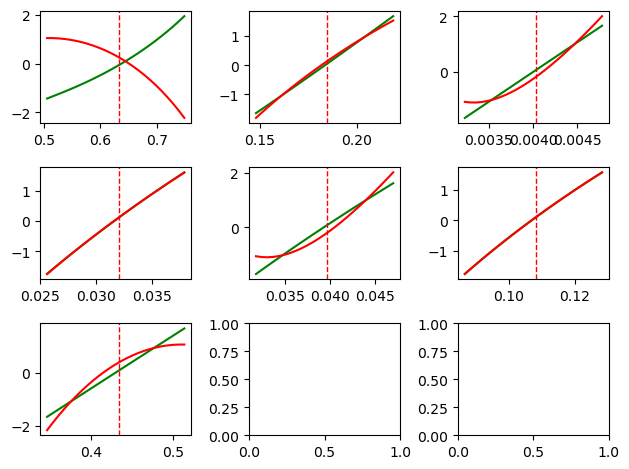

In [38]:
thetamode = res.x
thetaup = thetamode*1.2
thetadw = thetamode*0.8
KF.modecheck(get_minus_log_like, thetamode, thetaup, thetadw, data,others)

In [39]:
Theta_hat = res.x
hess_inv = res.hess_inv.todense()
SDtheta_hat = np.diag(np.linalg.cholesky(hess_inv))

coef = ['omega1    ','w2       ','sigma2_ey ','sigma2_ug ',
        'sigma2_uy ','sigma2_ux ','sigma2_ugm','r      ']
for cc in range(7):
    print('%s  %2.4f  (%1.5f)'%(coef[cc],Theta_hat[cc],SDtheta_hat[cc]))


omega1      0.6325  (1.00001)
w2         0.1849  (1.00015)
sigma2_ey   0.0040  (0.03273)
sigma2_ug   0.0320  (0.25547)
sigma2_uy   0.0397  (0.89759)
sigma2_ux   0.1083  (0.26187)
sigma2_ugm  0.4335  (0.99996)


Simular mediante Metropolis-Hasting

In [40]:
np.random.seed( 0 ) # Fijando la semilla (reproducir resultados)
theta0 = res.x
n = 10**3
b = 10**1
LTOmega = np.linalg.cholesky(res.hess_inv.todense())
matprint(LTOmega)

1.00001  0  0  0  0  0  0
-7.22927e-05  1.00015  0  0  0  0  0
6.93891e-05  0.00025541  0.0327286  0  0  0  0
-0.0016384  0.00685726  1.00173  0.255474  0  0  0
-0.000254279  0.00107417  -0.0868215  0.436544  0.897587  0  0
-0.000706506  0.00287318  -0.198477  -0.0589074  0.0217755  0.261873  0
-1.08837e-05  4.5841e-05  0.00297025  -0.00761945  0.00417323  0.00182342  0.99996


In [41]:
scale = 0.03
thetasim,a,smoothed = KF.get_MHsim(n,b,get_minus_log_posterior,theta0,LTOmega,scale,data,u_prior,s2_prior)

                                                  ]
 R. Acc. = 0.00

c:\Users\buser\OneDrive - BCRP\CursoVerano\MetodosNumericos\2024\08_python\KFstuff.py:300: RuntimeWarning: invalid value encountered in sqrt
  sd_au[:, t - 1] = sqrta(diag(Pu[:, :, t - 1]))
c:\Users\buser\OneDrive - BCRP\CursoVerano\MetodosNumericos\2024\08_python\KFstuff.py:293: RuntimeWarning: invalid value encountered in sqrt
  sd_v[:, t - 1] = sqrta(diag(F[:, :, t - 1]))
c:\Users\buser\OneDrive - BCRP\CursoVerano\MetodosNumericos\2024\08_python\KFstuff.py:377: RuntimeWarning: invalid value encountered in sqrt
  sd_as[:, t - 1] = sqrta(diag(Ps[:, :, t - 1]))


--------------------------------------------------]R. Acc. = 13.49


In [42]:
a # Ratio de aceptación

13.366336633663368

Integración de montecarlo

In [43]:
smoothed_mean = np.percentile(smoothed, 50, axis=-1)
smoothed_Q5 = np.percentile(smoothed, 5, axis=-1)
smoothed_Q95 = np.percentile(smoothed, 95, axis=-1)

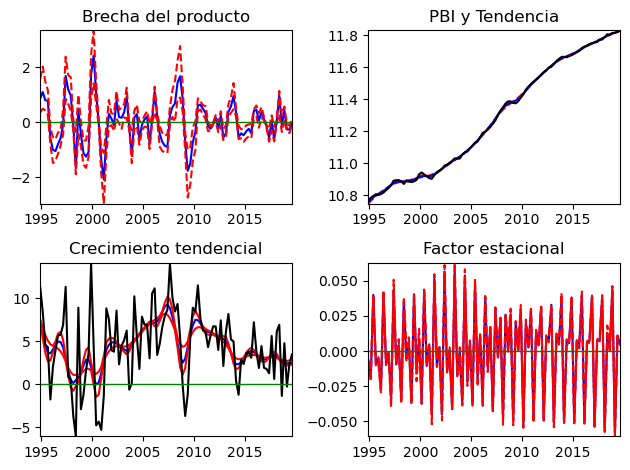

In [44]:
plot_Clark(lastperiods,smoothed_mean,smoothed_Q95,smoothed_Q5,dates)